# 使用 GAN 生成手写数据

In [1]:
import pickle as pkl

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

## 1.导入数据

In [2]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 2.定义图(Graph)

### 2.1 输入定义

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

### 2.2 生成器和辨别器

In [4]:
# 生成器
def generator(z, out_dim, n_units=128, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # z => relu => tanh
        h1 = tf.layers.dense(z, n_units, activation=None)

        h1 = tf.maximum(0.0, h1)

        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)

        return out

In [5]:
# 辨别器
def discriminator(z, n_units=128, reuse=False, alpha=.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # z(or inputs_real) => leakyrelu => sigmoid
        h1 = tf.layers.dense(z, n_units, activation=None)

        h1 = tf.maximum(alpha * h1, h1)

        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)

        return out, logits

## 2.3超参数

In [6]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

## 2.4 构建网络

In [7]:
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## 2.5 辨别器和分类器损失

In [8]:
# Calculate losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

## 2.6 优化器定义

In [9]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 3.在 Session 中计算图并训练

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []

saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
                
            # 得到图片并 reshape 
            batch_images = batch[0].reshape((batch_size, 784))
            # ???
            batch_images = batch_images * 2 - 1
            # 生成 fake 图片
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            # 运行优化器函数
            _ = sess.run(d_train_opt, feed_dict={
                input_real: batch_images,
                input_z: batch_z
            })
            _ = sess.run(g_train_opt, feed_dict={
                input_z: batch_z
            })
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = sess.run(g_loss, {input_z: batch_z})
        
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        
        losses.append((train_loss_d, train_loss_g))
        
        # 查看结果
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        
        saver.save(sess, './checkpoints/generator.ckpt')
        
    
# 保存训练 generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        

Epoch 1/100... Discriminator Loss: 0.3740... Generator Loss: 4.3202
Epoch 2/100... Discriminator Loss: 0.5056... Generator Loss: 2.8695
Epoch 3/100... Discriminator Loss: 3.2182... Generator Loss: 5.8436
Epoch 4/100... Discriminator Loss: 1.1405... Generator Loss: 2.3494
Epoch 5/100... Discriminator Loss: 1.1180... Generator Loss: 3.0634
Epoch 6/100... Discriminator Loss: 3.6692... Generator Loss: 1.9400
Epoch 7/100... Discriminator Loss: 0.6101... Generator Loss: 2.9906
Epoch 8/100... Discriminator Loss: 4.5406... Generator Loss: 0.6815
Epoch 9/100... Discriminator Loss: 2.0244... Generator Loss: 1.2607
Epoch 10/100... Discriminator Loss: 1.0015... Generator Loss: 1.5865
Epoch 11/100... Discriminator Loss: 0.8300... Generator Loss: 1.7076
Epoch 12/100... Discriminator Loss: 1.4031... Generator Loss: 1.6921
Epoch 13/100... Discriminator Loss: 0.6291... Generator Loss: 2.6812
Epoch 14/100... Discriminator Loss: 0.7572... Generator Loss: 2.3817
Epoch 15/100... Discriminator Loss: 0.9897.

# 4.结果分析

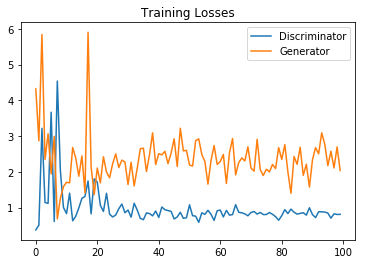

In [11]:
# 绘制 LOSS 曲线
%matplotlib inline

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# 5.生成图片

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

# 载入训练时的样本
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

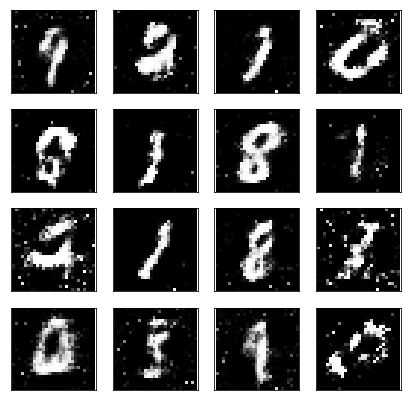

In [13]:
_ = view_samples(-1, samples)

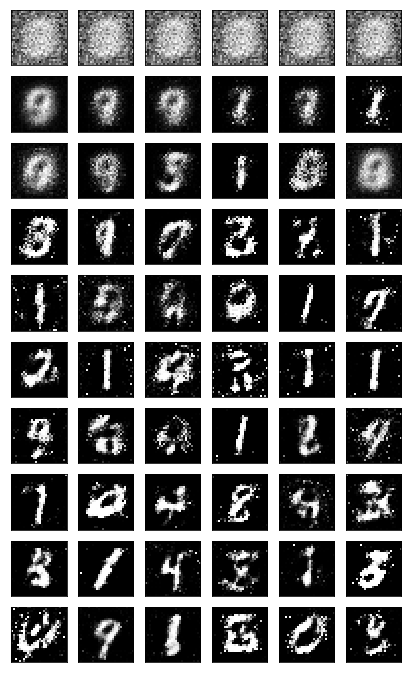

In [14]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [15]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


TypeError: generator() got an unexpected keyword argument 'alpha'